Notebook Link: https://colab.research.google.com/drive/1F4Za-tKdeUaqQDomnx6oyTjxo6Q1MHey?usp=sharing

codalab username: shashwat.pandey

Student ID: spandey7

## **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import random
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,make_scorer
#Randomizing Training Set
seed=1
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

## **Loading Dataset**

In [2]:
train_df=pd.read_csv('/content/drive/MyDrive/NLP243-Assignments/hw2_train_20221024.csv') #Training Set
train_df.head()

,ID,UTTERANCES,IOB SLOT TAGS
0,569,director for pride and prejudice,O O B_movie I_movie I_movie
1,1132,list some of the best world war 2 films,O O O O O B_subject I_subject I_subject O
2,2094,please provide the name of the company that pr...,O O O O O O O O O B_movie
3,767,search for russian movies,O O B_country O
4,1199,rating g,O B_mpaa_rating


In [3]:
test_df=pd.read_csv('/content/drive/MyDrive/NLP243-Assignments/hw2_test.csv') #Test Set
test_df.head()

,ID,UTTERANCES
0,0,star of thor
1,1,who is in the movie the campaign
2,2,list the cast of the movie the campaign
3,3,who was in twilight
4,4,who is in vulguria


## **Train-Test Split and Preprocessing**

In [4]:
x_test=test_df['UTTERANCES'].values
#Using traintestsplit to create training and validation set
x_train, x_val, y_train, y_val = train_test_split(train_df['UTTERANCES'].values, train_df['IOB SLOT TAGS'].values, 
                                test_size=0.2, random_state=1, shuffle=True)

In [5]:
#Creating vocabulary list from utterances
all_sents=x_train.tolist()+x_val.tolist()+x_test.tolist()
vocab=[]
for i in all_sents:
    vocab+=i.split(" ")
vocab=set(vocab)
print ('Vocab length:',len(vocab))

Vocab length: 1481


In [6]:
#Padding the utterances for uniform length and creating their key value pairs with unique identifiers
vocab=['<PAD>']+list(vocab)
word2idx={vocab[i]:i for i in range(len(vocab))}
idx2word={i:vocab[i] for i in range(len(vocab))}
assert len(word2idx)==len(idx2word)

In [7]:
#Creating label/tag list
all_tags=y_train.tolist()+y_val.tolist()
tags=[]
for i in all_tags:
    tags+=i.split()
tags=set(tags)
print ('tags length:',len(tags))

tags length: 27


In [8]:
#Padding the tags for uniform length and creating their key value pairs with unique identifiers
tags=['<PAD>']+list(tags)
tag2idx={tags[i]:i for i in range(len(tags))}
idx2tag={i:tags[i] for i in range(len(tags))}
assert len(tag2idx)==len(idx2tag)


In [9]:
#Vectorizing Vocabulary and Tags
def vectorize_vocab(word2idx,*argv):
    groups=[]
    for sents in argv[0]:
        groups.append([[word2idx[j] for j in i.split()] for i in sents])
    return groups

x_train,x_val,x_test=vectorize_vocab(word2idx,[x_train,x_val,x_test])
max_len=max([len(i) for i in x_train])

y_train,y_val=vectorize_vocab(tag2idx,[y_train,y_val])
assert max_len==max([len(i) for i in y_train])

## **Data Loader**

In [10]:
class MovieData(Dataset):
    def __init__(self, X, y):
      #Converting arrays to tensors of torch
        try:
            self.X = torch.tensor(X)
        except ValueError as e:
            self.X = [torch.tensor(i) for i in X]
        self.y = [torch.tensor(i) for i in y]

    def __len__(self):
        return len(self.y)

    def __getitem__(self,index):
        return self.X[index], self.y[index]

#Checking tensor length
def sort_batch(x):
    longest = max([len(i[0]) for i in x]) + 1
    s=torch.stack([torch.concat([i[0],torch.zeros(longest-len(i[0])).long()]) for i in x])
    l=torch.stack([torch.concat([i[1],torch.zeros(longest-len(i[1])).long()]) for i in x])
    return s,l

In [11]:
train_dataset = MovieData(X=x_train,y=y_train)
val_dataset = MovieData(X=x_val,y=y_val)
bs=32
#DataLoader Definition
train_dataloader = DataLoader(dataset=train_dataset,collate_fn=sort_batch,batch_size=bs,shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,collate_fn=sort_batch,batch_size=bs,shuffle=True)

## **Model Class**

In [12]:
#Class for a 3 layer LSTM Model
class LSTM_1(nn.Module):
    def __init__(self,vocab_size,embed_dim,num_class,hidden_size,padding_index=0):
        super(LSTM_1,self).__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_index) #Layer 1
        self.dropout = nn.Dropout(0.2) #Layer 2
        self.rnn=nn.LSTM(input_size=embed_dim,hidden_size=hidden_size,num_layers=2,batch_first=True,bidirectional=True) #Layer 3
        self.fc1= nn.Linear(hidden_size*2,num_class) #Layer 4 (to match output dimension)
    def forward(self,x):
        x=self.dropout(self.emb(x))
        out,h_n=self.rnn(x)
        h1=self.fc1(out)
        h2=h1.view(-1, h1.shape[-1]) #Reshaping tensors from 3D to 2D
        return h2

embed_size=300 #Embedding layer dimension
hidden_size=64 #Hidden Layer dimensions
loss_func = nn.CrossEntropyLoss()


In [13]:
clf = LSTM_1(vocab_size=len(vocab),embed_dim=embed_size,num_class=len(tags),hidden_size=hidden_size) #Creating Model Object
learning_rate=0.01
num_epochs=15
optimizer = optim.Adam(clf.parameters(), lr=learning_rate)
losses = []
train_losses,train_acc = [],[]
val_losses, val_acc=[],[]
min_loss=1000
total_step=len(train_dataloader)

## **Training Loop**

In [ ]:
for epoch in range(num_epochs): #Running Epoch loop
    train_loss,correct=0,0
    total_tags=0
    total_val_tags=0
    for i,(X,y) in enumerate(train_dataloader): #Training evaluation loop for each batch size
        optimizer.zero_grad()
        y_pred = clf(X)
        y=y.view(-1)
        loss = loss_func(y_pred, y)
        train_loss+=loss.item()
        y_pred=torch.argmax(y_pred,dim=1)
        y_pred,y=y_pred.flatten(),y.flatten()
        correct+= (y_pred==y).sum().item()
        total_tags+=y.shape[0]     
        loss.backward()
        optimizer.step()
        if (i+1) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    train_loss=round(train_loss/len(val_dataloader),3)
    acc=round(100*correct/total_tags,3)
    train_losses.append(train_loss)
    train_acc.append(acc)
    print (f"Train loss: {train_loss} Train accuracy: {acc}")  
    val_loss,correct=0,0
    for i,(X,y) in enumerate(val_dataloader): #Validation evaluation loop for each batch size
        y_pred = clf(X)
        y=y.view(-1)
        loss = loss_func(y_pred, y)
        val_loss+= round(loss.item(),3)
        y_pred=torch.argmax(y_pred,dim=1)
        y_pred,y=y_pred.flatten(),y.flatten()
        correct+= (y_pred==y).sum().item()
        total_val_tags+=len(y)
        
    val_loss=round(val_loss/len(val_dataloader),3)
    if(val_loss<min_loss):
        print ('\nSaving best model...')
        min_loss=val_loss
        torch.save(clf.state_dict(), './best_model.pt')

    val_losses.append(val_loss)
    acc=round(100*correct/total_val_tags,3)
    val_acc.append(acc)
    print (f'Valid loss: {val_loss} Valid acc: {acc}')
    print ('\n'+'='*20)

## **Training Plot**

In [15]:
import matplotlib.pyplot as plt
import numpy as np
#Plotting Accuracy and Loss Graphs
def plot_graph(plot_var,train_plot_list,val_plot_list):
    epochs = len(train_plot_list)
    fig = plt.figure(figsize=(8,6))
    if plot_var=="accuracy": plt.title("Train/Validation Accuracy")
    elif plot_var =="loss" : plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_plot_list, label='train')
    plt.plot(list(np.arange(epochs) + 1), val_plot_list, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    if plot_var=="accuracy": plt.savefig('Train_Val_accuracy.png')
    elif plot_var =="loss" : plt.savefig("Train_Val_loss.png")
    return

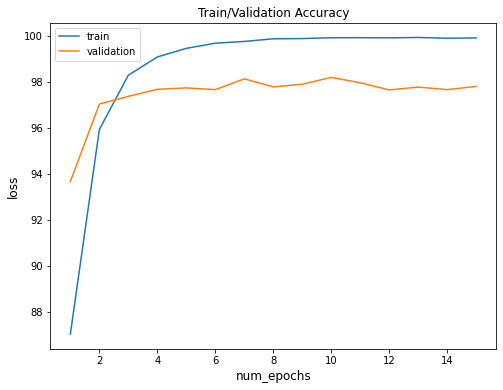

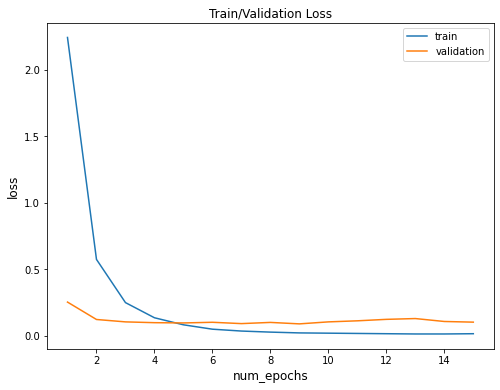

In [16]:
plot_graph("accuracy",train_acc, val_acc)
plot_graph("loss",train_losses, val_losses)

## **Prediction**

In [17]:
preds=[] #List for each tag
preds_sent=[] #List of string of tags for every utterance
for i,X in enumerate(x_test):
    y_pred = clf(torch.tensor(X).unsqueeze(0))
    y_pred=torch.argmax(y_pred,dim=1)
    preds_sent.append(y_pred.detach().numpy().tolist())
    preds+=y_pred.detach().numpy().tolist()

preds=[idx2tag[i] for i in preds]
preds_sent=[(' ').join([idx2tag[j] for j in i]) for i in preds_sent]
preds_ = pd.DataFrame(zip(range(len(preds_sent)),preds_sent),columns=['ID','IOB Slot tags'])
preds_.head()

,ID,IOB Slot tags
0,0,O O B_movie
1,1,O O O O O B_movie I_movie
2,2,O O O O O O B_movie I_movie
3,3,O O O B_movie
4,4,O O O B_movie


In [18]:
preds_ = preds_.astype({'IOB Slot tags':'string'})

In [19]:
preds_["IOB Slot tags"] = preds_["IOB Slot tags"].str.replace("<PAD>",'O')

In [20]:
preds_.to_csv('./submission.csv',index=None)